In [ ]:
from google.colab import files
from drive.MyDrive.simple_model_definition import networkLinear, LinearBlock, identityNN
from drive.MyDrive.gev_loss import simpleGEVloss
from drive.MyDrive.dataloaders import BaseDataLoader, DataLoader2
from drive.MyDrive.training_modules import NeuralTrainer, Diagnostic
from drive.MyDrive.schedulers import CyclicCosAnnealingLR, CyclicLinearLR
from drive.MyDrive.models_class1 import ModuleCustom, Model_unique_station

In [ ]:
import numpy as np
import pandas as pd
import scipy as sc
import torch
import matplotlib.pyplot as plt

import math
import time
import numpy as np

import torch
import torch.nn as nn
from torch.nn import LSTM
import torch.nn.functional as F

from torch.autograd import Variable
from torch.optim.lr_scheduler import _LRScheduler
from torch.optim.optimizer import Optimizer

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

In [ ]:
monthly_maxima = pd.read_csv("/content/drive/MyDrive/data_monthly_weights.csv")
monthly_maxima.drop("Unnamed: 0", inplace = True, axis=1)
monthly_maxima

,id,year,month,dur,nb_obs,int,X,Y,basin,alt
0,69505,2001,Apr,1440,28,2.229,-84.148057,10.165240,69,1899
1,69505,2006,Feb,10,16,30.600,-84.148057,10.165240,69,1899
2,69505,2005,May,10,21,50.400,-84.148057,10.165240,69,1899
3,69505,2012,Feb,180,17,7.700,-84.148057,10.165240,69,1899
4,69505,2015,Jan,30,26,11.200,-84.148057,10.165240,69,1899
...,...,...,...,...,...,...,...,...,...,...
359203,98080,2013,Apr,60,14,26.900,-83.386662,9.080118,98,434
359204,98080,2008,Jun,120,25,21.950,-83.386662,9.080118,98,434
359205,98080,2019,Mar,60,6,4.300,-83.386662,9.080118,98,434
359206,98080,2008,May,120,24,21.850,-83.386662,9.080118,98,434


In [ ]:
monthly_maxima["w"] = monthly_maxima["nb_obs"]
dict_days_per_month = {"Jan": 31, "Feb": 29, "Mar": 31, "Apr": 30, "May": 31, "Jun": 30,
                       "Jul": 31, "Aug": 31, "Sep": 30, "Oct": 31, "Nov": 30, "Dec": 31}
def transform_obs_to_weight(x):
  return x["nb_obs"]/dict_days_per_month[x["month"]]

monthly_maxima["w"] = monthly_maxima.apply(lambda x: transform_obs_to_weight(x), axis = 1)
monthly_maxima

,id,year,month,dur,nb_obs,int,X,Y,basin,alt,w
0,69505,2001,Apr,1440,28,2.229,-84.148057,10.165240,69,1899,0.933333
1,69505,2006,Feb,10,16,30.600,-84.148057,10.165240,69,1899,0.551724
2,69505,2005,May,10,21,50.400,-84.148057,10.165240,69,1899,0.677419
3,69505,2012,Feb,180,17,7.700,-84.148057,10.165240,69,1899,0.586207
4,69505,2015,Jan,30,26,11.200,-84.148057,10.165240,69,1899,0.838710
...,...,...,...,...,...,...,...,...,...,...,...
359203,98080,2013,Apr,60,14,26.900,-83.386662,9.080118,98,434,0.466667
359204,98080,2008,Jun,120,25,21.950,-83.386662,9.080118,98,434,0.833333
359205,98080,2019,Mar,60,6,4.300,-83.386662,9.080118,98,434,0.193548
359206,98080,2008,May,120,24,21.850,-83.386662,9.080118,98,434,0.774194


In [ ]:
stations_training_testing = pd.read_csv("/content/drive/MyDrive/data_training_testing.csv")
stations_training_testing.drop("Unnamed: 0", inplace = True, axis=1)
stations_training_testing

,id,train
0,73046,True
1,78020,True
2,98015,True
3,69576,True
4,98043,True
...,...,...
156,88026,False
157,88040,False
158,98006,False
159,98017,False


In [ ]:
list_stations_training = stations_training_testing[stations_training_testing["train"] == True]["id"]
list_stations_testing = stations_training_testing[stations_training_testing["train"] == False]["id"]
print(*list_stations_training, sep = ", ")
print("----------")
print(*list_stations_testing, sep = ", ")

73046, 78020, 98015, 69576, 98043, 69654, 79012, 84122, 84136, 88028, 76012, 69524, 84124, 69698, 73124, 88034, 79020, 69542, 88018, 69522, 69700, 73055, 98023, 98021, 75028, 73098, 88024, 73074, 98057, 98050, 88032, 79010, 98020, 69544, 69628, 98059, 69624, 76033, 76050, 69670, 69570, 69547, 98036, 98039, 94014, 73042, 75007, 84043, 69530, 69694, 84130, 69662, 76048, 69632, 75004, 69598, 69596, 69581, 69553, 84034, 74036, 69563, 69612, 76006, 98037, 79014, 74019, 69630, 69696, 69668, 69604, 73134, 69550, 84096, 69571, 76044, 76018, 73028, 69686, 78018, 73140, 69532, 76024, 98058, 69572, 76020, 73079, 75003, 98044, 98034, 69505, 73128, 76013, 69552, 75005, 98019, 76021, 98012, 98080, 98078, 88020, 87010, 76038, 69548, 69545, 88023, 69574, 73027, 69549, 69636, 69561, 98011, 84114, 98040, 69520, 76022, 88030, 78002, 73148, 76036, 75002, 73047, 69578
----------
69507, 69551, 69582, 69583, 69587, 69588, 69589, 69608, 69614, 69616, 69620, 69626, 69634, 69638, 69656, 69674, 69682, 73011, 730

In [ ]:
# # create training stations
# list_of_stations = list(set(monthly_maxima["id"]))

# # Include stations 69507, 77001, 76026, 84118, 98006 and 75022 in testing (six stations of study)
# extra_stations_to_include_in_testing = [69507, 77001, 76026, 84118, 98006, 75022]
# # stations that are typically far from others (this step could be automated...)
# extra_stations_to_include_in_training = [69578, 87010, 94014, 78020] 

# indices = np.random.choice(len(list_of_stations), size = int(len(list_of_stations) * 0.8), replace = False)
# list_stations_training = [list_of_stations[i] for i in indices if (list_of_stations[i] not in extra_stations_to_include_in_testing)]
# list_stations_training.extend(extra_stations_to_include_in_training)
# list_stations_training = list(set(list_stations_training))

# list_stations_testing = [list_of_stations[i] for i, l in enumerate(list_of_stations) if (list_of_stations[i] not in list_stations_training)]
# print(*list_stations_training, sep = ", ")
# print("----------")
# print(*list_stations_testing, sep = ", ")

In [ ]:
# Settings
Station_of_interest = None           # if None, all station used
Duration_of_interest = "all"         # if "all", all durations are used. Otherwise, must be amond [5, 10, ..., 1440]

# Training
Proportion_of_stations_test = 0.1    # ~ 16 stations will be used as validation
Train_dataset_relative_size = 0.8    # 80% of observation is used for training
Nb_time_dataset_is_recreated = 10    # retrain model 10 times on a new dataset, following previous settings
Nb_bootstrapping = 5                 # for each dataset, fit model 5 times (potentially using residual bootstrapping or something similar)

Order_basis = 2
use_seed = None

In [ ]:
monthly_maxima_labelMonth = monthly_maxima.copy()
look_up = {'01': 'Jan', '02': 'Feb', '03': 'Mar', '04': 'Apr', '05': 'May',
            '06': 'Jun', '07': 'Jul', '08': 'Aug', '09': 'Sep', '10': 'Oct', '11': 'Nov', '12': 'Dec'}
look_up_inv = {v: int(i) for i, (k, v) in enumerate(look_up.items())}
monthly_maxima_labelMonth['month'] = monthly_maxima_labelMonth['month'].map(look_up_inv)

In [ ]:
for j in range(Order_basis):
    monthly_maxima_labelMonth['month_cos_'+str(j)] = np.cos((j+1)*2*np.pi * monthly_maxima_labelMonth['month'] / 12)
    monthly_maxima_labelMonth['month_sin_'+str(j)] = np.sin((j+1)*2*np.pi * monthly_maxima_labelMonth['month'] / 12)
# monthly_maxima_labelMonth = monthly_maxima_labelMonth.loc[(monthly_maxima_labelMonth.loc[:,'id'] == station_of_interest), :]
monthly_maxima_labelMonth

,id,year,month,dur,nb_obs,int,X,Y,basin,alt,w,month_cos_0,month_sin_0,month_cos_1,month_sin_1
0,69505,2001,3,1440,28,2.229,-84.148057,10.165240,69,1899,0.933333,6.123234e-17,1.000000,-1.0,1.224647e-16
1,69505,2006,1,10,16,30.600,-84.148057,10.165240,69,1899,0.551724,8.660254e-01,0.500000,0.5,8.660254e-01
2,69505,2005,4,10,21,50.400,-84.148057,10.165240,69,1899,0.677419,-5.000000e-01,0.866025,-0.5,-8.660254e-01
3,69505,2012,1,180,17,7.700,-84.148057,10.165240,69,1899,0.586207,8.660254e-01,0.500000,0.5,8.660254e-01
4,69505,2015,0,30,26,11.200,-84.148057,10.165240,69,1899,0.838710,1.000000e+00,0.000000,1.0,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
359203,98080,2013,3,60,14,26.900,-83.386662,9.080118,98,434,0.466667,6.123234e-17,1.000000,-1.0,1.224647e-16
359204,98080,2008,5,120,25,21.950,-83.386662,9.080118,98,434,0.833333,-8.660254e-01,0.500000,0.5,-8.660254e-01
359205,98080,2019,2,60,6,4.300,-83.386662,9.080118,98,434,0.193548,5.000000e-01,0.866025,-0.5,8.660254e-01
359206,98080,2008,4,120,24,21.850,-83.386662,9.080118,98,434,0.774194,-5.000000e-01,0.866025,-0.5,-8.660254e-01


In [ ]:
import calendar
month_names = list(calendar.month_abbr)[1:13]
months_one_hot_encoding = pd.get_dummies(monthly_maxima["month"])[month_names]

monthly_maxima = pd.concat([monthly_maxima, months_one_hot_encoding], axis=1)
monthly_maxima.drop("month", axis = 1, inplace = True)
monthly_maxima = monthly_maxima.astype('float64', copy = False)
monthly_maxima

,id,year,dur,nb_obs,int,X,Y,basin,alt,w,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
0,69505.0,2001.0,1440.0,28.0,2.229,-84.148057,10.165240,69.0,1899.0,0.933333,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,69505.0,2006.0,10.0,16.0,30.600,-84.148057,10.165240,69.0,1899.0,0.551724,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,69505.0,2005.0,10.0,21.0,50.400,-84.148057,10.165240,69.0,1899.0,0.677419,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,69505.0,2012.0,180.0,17.0,7.700,-84.148057,10.165240,69.0,1899.0,0.586207,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,69505.0,2015.0,30.0,26.0,11.200,-84.148057,10.165240,69.0,1899.0,0.838710,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
359203,98080.0,2013.0,60.0,14.0,26.900,-83.386662,9.080118,98.0,434.0,0.466667,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
359204,98080.0,2008.0,120.0,25.0,21.950,-83.386662,9.080118,98.0,434.0,0.833333,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
359205,98080.0,2019.0,60.0,6.0,4.300,-83.386662,9.080118,98.0,434.0,0.193548,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
359206,98080.0,2008.0,120.0,24.0,21.850,-83.386662,9.080118,98.0,434.0,0.774194,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
monthly_maxima_labelMonth

,id,year,month,dur,nb_obs,int,X,Y,basin,alt,w,month_cos_0,month_sin_0,month_cos_1,month_sin_1
0,69505,2001,3,1440,28,2.229,-84.148057,10.165240,69,1899,0.933333,6.123234e-17,1.000000,-1.0,1.224647e-16
1,69505,2006,1,10,16,30.600,-84.148057,10.165240,69,1899,0.551724,8.660254e-01,0.500000,0.5,8.660254e-01
2,69505,2005,4,10,21,50.400,-84.148057,10.165240,69,1899,0.677419,-5.000000e-01,0.866025,-0.5,-8.660254e-01
3,69505,2012,1,180,17,7.700,-84.148057,10.165240,69,1899,0.586207,8.660254e-01,0.500000,0.5,8.660254e-01
4,69505,2015,0,30,26,11.200,-84.148057,10.165240,69,1899,0.838710,1.000000e+00,0.000000,1.0,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
359203,98080,2013,3,60,14,26.900,-83.386662,9.080118,98,434,0.466667,6.123234e-17,1.000000,-1.0,1.224647e-16
359204,98080,2008,5,120,25,21.950,-83.386662,9.080118,98,434,0.833333,-8.660254e-01,0.500000,0.5,-8.660254e-01
359205,98080,2019,2,60,6,4.300,-83.386662,9.080118,98,434,0.193548,5.000000e-01,0.866025,-0.5,8.660254e-01
359206,98080,2008,4,120,24,21.850,-83.386662,9.080118,98,434,0.774194,-5.000000e-01,0.866025,-0.5,-8.660254e-01


In [ ]:
from sklearn.model_selection import train_test_split

name_covariates = ["X", "Y", "alt", "dur"] # <- /!\ adjust next
# name_covariates = ["dur", "X", "Y", "alt"]
for j in range(Order_basis):
  name_covariates.append('month_cos_'+str(j))
  name_covariates.append('month_sin_'+str(j))

X_input = monthly_maxima_labelMonth[monthly_maxima_labelMonth["id"].isin(list_stations_training)][name_covariates]
Y_output = monthly_maxima_labelMonth[monthly_maxima_labelMonth["id"].isin(list_stations_training)][["int", "dur", "w"]]

X_train, X_test, y_train, y_test = train_test_split(X_input,Y_output,test_size=0.2,random_state=42)
print(X_train)
print(y_train)

                X          Y   alt  ...   month_sin_0  month_cos_1   month_sin_1
254831 -83.378861   9.775236   589  ... -5.000000e-01          0.5 -8.660254e-01
34293  -84.853097  10.511281   573  ...  1.224647e-16          1.0 -2.449294e-16
295599 -83.912944   9.645533  1933  ...  1.000000e+00         -1.0  1.224647e-16
28533  -84.717030  10.438884   604  ...  5.000000e-01          0.5 -8.660254e-01
338184 -83.337572   8.942579    80  ...  5.000000e-01          0.5 -8.660254e-01
...           ...        ...   ...  ...           ...          ...           ...
170954 -83.600140   9.799149  1450  ...  5.000000e-01          0.5 -8.660254e-01
346288 -82.831395   8.931999  1394  ...  8.660254e-01         -0.5 -8.660254e-01
186842 -85.361695  10.759248   641  ...  5.000000e-01          0.5 -8.660254e-01
204290 -83.564764   9.901078   894  ... -8.660254e-01         -0.5  8.660254e-01
175203 -83.571898  10.079840   206  ... -1.000000e+00         -1.0  3.673940e-16

[217678 rows x 8 columns]
 

In [ ]:
from sklearn.preprocessing import MinMaxScaler
pd.options.mode.chained_assignment = None  # default='warn'

scaler = MinMaxScaler()

# X_train["dur"] = np.log(X_train["dur"])
# X_test["dur"] = np.log(X_test["dur"])

X_train.loc[:, ['X', 'Y', 'alt']] = scaler.fit_transform(X_train[['X', 'Y', 'alt']])
X_test.loc[:, ['X', 'Y', 'alt']] = scaler.transform(X_test[['X', 'Y', 'alt']])
X_train_tensor = torch.from_numpy(X_train.to_numpy())
y_train_tensor = torch.from_numpy(y_train.to_numpy())
X_test_tensor = torch.from_numpy(X_test.to_numpy())
y_test_tensor = torch.from_numpy(y_test.to_numpy())
X_train_tensor.shape

torch.Size([217678, 8])

In [ ]:
class Model_unique_station(ModuleCustom):
  def __init__(self, linearBlock, 
               duration_theta_eta = False, 
               remove_first_input_dim = False,
               constrain_xi = True,
               model_duration = False):
    super(Model_unique_station, self).__init__()
    self.linearBlock = linearBlock
    self.duration_theta_eta = duration_theta_eta
    self.remove_first_input_dim = remove_first_input_dim
    self.constrain_xi = constrain_xi
    self.model_duration = model_duration

  def forward(self, input):
    if self.model_duration:
      return self.forward_model_duration(input)

    # device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    device = input.get_device()
    if self.remove_first_input_dim:
      x = self.linearBlock(input[:, 1:])
    else:
      x = self.linearBlock(input)

    x1 = torch.tensor([[1, 0, 0]], device = device) * x[:, 0:3]   # location: not constrained
    x2 = torch.tensor([[0, 1, 0]], device = device) * torch.exp(x[:, 0:3]+1e-5)     # scale: constrained in interval [1e-5, Inf]
    if self.constrain_xi:
      x3 = torch.tensor([[0, 0, 1]], device = device) * self.bounded_output(x[:, 0:3], -0.5, 1.0)        # shape: constrained in interval [-0.5, 1.0]
    else:
      x3 = torch.tensor([[0, 0, 1]], device = device) * x[:, 0:3]
      # x3 = torch.tensor([[0, 0, 1]], device = device) * torch.exp(x[:, 0:3]) - 0.5
    y = x1+x2+x3

    if self.duration_theta_eta:
      y1 = torch.tensor([[1, 1, 0]], device = device) * y * (input[:,0].view(-1, 1) + torch.exp(x[:, 3]).view(-1, 1))**(-torch.sigmoid(x[:, 4]).view(-1, 1))
      y2 = torch.tensor([[0, 0, 1]], device = device) * y
      y = y1+y2

    # y = torch.tensor([[1, 1, 0]], device = device) * y * (input[:,0].view(-1, 1) + torch.exp(x[:, 3]).view(-1, 1))**(-torch.sigmoid(x[:, 4]).view(-1, 1)) + torch.tensor([[0, 0, 1]], device = device) * y
    return y

  def bounded_output(self, x, lower, upper):
    scale = upper - lower
    return scale * torch.sigmoid(x) + lower


  def forward_model_duration(self, input):
    device = input.get_device()
    x = self.linearBlock(input)
    x1 = torch.tensor([[1, 0, 0, 0, 0]], device = device) * x[:, 0:5]   # location: not constrained
    x2 = torch.tensor([[0, 1, 0, 0, 0]], device = device) * torch.exp(x[:, 0:5]+1e-5)     # scale: constrained in interval [1e-5, Inf]
    x3 = torch.tensor([[0, 0, 1, 0, 0]], device = device) * self.bounded_output(x[:, 0:5], -0.5, 1.0)
    # x4 = torch.tensor([[0, 0, 0, 1, 0]], device = device) * torch.exp(x[:, 0:5]+1e-5)
    # x5 = torch.tensor([[0, 0, 0, 0, 1]], device = device) * torch.sigmoid(x[:, 0:5]+1e-5)
    x4 = torch.tensor([[0, 0, 0, 1, 0]], device = device) * x[:, 0:5]
    x5 = torch.tensor([[0, 0, 0, 0, 1]], device = device) * x[:, 0:5]
    y = x1+x2+x3+x4+x5
    return y


class GEVloss_extended(nn.Module):
    def __init__(self, use_weights = False, model_duration = False):
        super(GEVloss_extended, self).__init__()
        self.use_weights = use_weights
        self.model_duration = model_duration
        
    def forward(self, x, observed_values):
        """ x: [location, scale, shape],
        observed_values: [intensities, duration, weights] """
        location = x[:, 0]
        scale = x[:, 1]
        shape = x[:, 2]

        if self.model_duration:
          theta = x[:, 3]
          eta = x[:, 4]
          location = location * (observed_values[:, 1] + theta)**(-eta)
          scale = scale * (observed_values[:, 1] + theta)**(-eta)

        if self.use_weights:
          location = location - (scale/shape) * (1-observed_values[:, 2]**(shape))
          scale = scale * observed_values[:, 2]**(shape)

        term1 = torch.log(scale)
        term_inter_1 = 1.0 + shape * (observed_values[:, 0] - location)/scale
        term_inter_1[term_inter_1 <= 0] = 1e-16
        term3 = (1.0/shape + 1.0)* torch.log(term_inter_1)
        term4 = term_inter_1 ** (-1/shape)

        indices_small_shape = torch.abs(shape) < 1e-5
        term3 = 1.0*indices_small_shape * term3 + (1.0-1.0*indices_small_shape)*(observed_values[:, 0] - location)/scale
        term4 = 1.0*indices_small_shape * term4 + (1.0-1.0*indices_small_shape)*torch.exp(-(observed_values[:, 0] - location)/scale)

        res = term1 + term3 + term4
        return torch.nansum(res)


class DataLoader3(BaseDataLoader):
    def __init__(self, dataInput, dataOutput, batch_size, maxIterations = None):
        super(DataLoader3, self).__init__(dataInput, dataOutput, batch_size, maxIterations)
    
    def sample(self):
        chosen_data = np.random.choice(self.dataInput.shape[0], size = self.batch_size, replace = True)
        input_batch = self.dataInput[chosen_data, :]
        output_batch = self.dataOutput[chosen_data, :]
        return {'input': input_batch, 'output': output_batch}

    def getAlldata(self):
        input_batch = self.dataInput
        output_batch = self.dataOutput
        return {'input': input_batch, 'output': output_batch}

    def getSample(self, size = 1):
        chosen_data = np.random.choice(self.dataInput.shape[0], size = size, replace = True)
        input_batch = self.dataInput[chosen_data, :]
        output_batch = self.dataOutput[chosen_data, :]
        return {'input': input_batch, 'output': output_batch}

In [ ]:
class Model_unique_station_2(ModuleCustom):
  """ Location and scale depend on longitude, latitude, altitude, month and duration,
  shape on longitude, latitude, altitude and month (not duration) """

  def __init__(self, linearBlock_1, linearBlock_2, index_duration, input_dim):
    super(Model_unique_station_2, self).__init__()
    self.linearBlock_1 = linearBlock_1
    self.linearBlock_2 = linearBlock_2
    self.index_duration = index_duration
    self.indices = [l for l in range(input_dim) if l != index_duration]
    # self.duration_theta_eta = duration_theta_eta
    # self.remove_first_input_dim = remove_first_input_dim
    # self.constrain_xi = constrain_xi
    # self.model_duration = model_duration
    print(self.indices)

  def forward(self, input):

    x_1 = self.linearBlock_1(input) # dim 2
    x_2 = self.linearBlock_2(input[:,self.indices]) # dim 1

    x = torch.cat((x_1, x_2.view(-1, 1)), axis = 1)

    x1 = torch.tensor([[1, 0, 0]], device = device) * x[:, 0:3]   # location: not constrained
    x2 = torch.tensor([[0, 1, 0]], device = device) * torch.exp(x[:, 0:3]+1e-5)     # scale: constrained in interval [1e-5, Inf]
    x3 = torch.tensor([[0, 0, 1]], device = device) * self.bounded_output(x[:, 0:3], -0.5, 1.0)        # shape: constrained in interval [-0.5, 1.0]
    y = x1+x2+x3

    # y = torch.tensor([[1, 1, 0]], device = device) * y * (input[:,0].view(-1, 1) + torch.exp(x[:, 3]).view(-1, 1))**(-torch.sigmoid(x[:, 4]).view(-1, 1)) + torch.tensor([[0, 0, 1]], device = device) * y
    return y

  def bounded_output(self, x, lower, upper):
    scale = upper - lower
    return scale * torch.sigmoid(x) + lower

In [ ]:
from torch.autograd import Variable
import torch
import torch.nn as nn



linearBlock = nn.Sequential(*[nn.Linear(8, 200), nn.ReLU(), # nn.BatchNorm1d(100),
                              nn.Linear(200, 50), nn.ReLU(), # nn.BatchNorm1d(50),
                              nn.Linear(50, 20), nn.ReLU(),
                              nn.Linear(20, 10), nn.ReLU(),
                              nn.Linear(10, 3)])

model = Model_unique_station(linearBlock, model_duration = False)
# model = Model_unique_station_2(linearBlock, linearBlock2, index_duration = 3, input_dim = 8)

if torch.cuda.is_available():   
  model = model.cuda()
  device = "cuda"
else:
  device = "cpu"
dataloadertest = DataLoader3(X_train_tensor, y_train_tensor, 10)
sample_test = dataloadertest.sample()
print(sample_test['input'])

output = model(Variable(sample_test['input'].float().to(device)))
print(output)

criterion = GEVloss_extended(use_weights = False, model_duration = False)
loss = criterion(output, Variable(sample_test['output'].float().to(device)))
print(loss)

criterion = GEVloss_extended(use_weights = False, model_duration = False)
loss = criterion(output, Variable(sample_test['output'].float().to(device)))
print(loss)

tensor([[ 2.0186e-01,  8.3468e-01,  2.2716e-01,  1.2240e-01, -8.6603e-01,
          5.0000e-01,  5.0000e-01, -8.6603e-01],
        [ 6.0462e-01,  4.8998e-01,  3.9833e-01,  8.7760e-01,  6.1232e-17,
          1.0000e+00, -1.0000e+00,  1.2246e-16],
        [ 7.8846e-01,  6.0246e-02,  2.1684e-01,  1.9400e-01,  1.0000e+00,
          0.0000e+00,  1.0000e+00,  0.0000e+00],
        [ 2.3291e-01,  7.7350e-01,  2.9388e-01,  4.3880e-01, -8.6603e-01,
          5.0000e-01,  5.0000e-01, -8.6603e-01],
        [ 5.3936e-01,  5.6826e-01,  6.4813e-01,  1.0000e+00, -5.0000e-01,
          8.6603e-01, -5.0000e-01, -8.6603e-01],
        [ 1.8627e-01,  8.5214e-01,  2.3868e-01,  6.3280e-01, -5.0000e-01,
          8.6603e-01, -5.0000e-01, -8.6603e-01],
        [ 6.4180e-01,  4.7285e-01,  2.6608e-01,  3.1640e-01,  8.6603e-01,
          5.0000e-01,  5.0000e-01,  8.6603e-01],
        [ 4.9080e-01,  3.9269e-01,  5.6156e-01,  1.2240e-01, -5.0000e-01,
         -8.6603e-01, -5.0000e-01,  8.6603e-01],
        [ 7.2235

In [ ]:
from torch.nn.modules.batchnorm import BatchNorm1d
from os.path import join
from tqdm import tqdm
import warnings
warnings.simplefilter("always")
from torch import autograd
autograd.set_detect_anomaly(True)

# ---------- Hyperparameters ----------
LEARNING_RATE = 0.001 # 0.0001 (ModelUniqueStation), 0.001 (ModelUniqueStation1)
NUMBER_EPOCH = 3000
PATH_SAVE_DATA = "/content/drive/MyDrive/"
MODEL_NAME = "modelPDM7.pth.tar"
SAVE_MODEL_FREQUENCY = 10
BATCH_SIZE = 2000 # 2000 ModelUniqueStation)

# -------------------------------------

dataLoaderTraining = DataLoader3(X_train_tensor, y_train_tensor, BATCH_SIZE, maxIterations = 10)
dataLoaderTesting = DataLoader3(X_test_tensor, y_test_tensor, BATCH_SIZE, maxIterations = 10)

linearBlock = nn.Sequential(*[nn.Linear(8, 100), nn.Sigmoid(), # nn.BatchNorm1d(200),
                              nn.Linear(100, 50), nn.Sigmoid(), # nn.BatchNorm1d(100),
                              nn.Linear(50, 10), nn.Sigmoid(),
                              nn.Linear(10, 10), nn.Sigmoid(),
                              nn.Linear(10, 3)])
# linearBlock_1 = nn.Sequential(*[nn.Linear(8, 100), nn.Sigmoid(), 
#                               nn.Linear(100, 50), nn.Sigmoid(), 
#                               nn.Linear(50, 10), nn.Sigmoid(),
#                               nn.Linear(10, 10), nn.Sigmoid(),
#                               nn.Linear(10, 2)])
# linearBlock_2 = nn.Sequential(*[nn.Linear(7, 20), nn.Sigmoid(), 
#                               # nn.Linear(2, 50), nn.Sigmoid(), 
#                               # nn.Linear(20, 20), nn.Sigmoid(),
#                               # nn.Linear(20, 20), nn.Sigmoid(),
#                               nn.Linear(20, 1)])

# model = Model_unique_station(linearBlock, 
#                              duration_theta_eta = False, 
#                              remove_first_input_dim = False,
#                              constrain_xi = True,
#                              model_duration = False)
# model = Model_unique_station_2(linearBlock_1, linearBlock_2, index_duration = 3, input_dim = 8)

model = Model_unique_station(linearBlock, model_duration = False)

# if a GPU is available, move model to cuda
if torch.cuda.is_available():   
    model = model.cuda()
# model = model.to("cpu")

# Create the loss the train the model
criterion = GEVloss_extended(use_weights = False, model_duration = False)
# criterion = simpleGEVloss()

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# high frequency scheduler
lr_scheduler = CyclicCosAnnealingLR(optimizer, 
                                    milestones=[100, 150, 200, 250, 300, 350, 400, 450, 
                                                500, 600, 700, 800, 900, 1000, 1500, 2000, 2100, 2200, 2300, 2400, 2500, 3000],#, 4000, 5000, 10000], 
            eta_min = LEARNING_RATE/100) # 10 (ModelUniqueStation)

# Keep track of the loss for training and validation, and the best loss achieved w.r.t. validation score
diagnostic = Diagnostic(channels = ["TRAINING", "TESTING"], length = NUMBER_EPOCH,
            path_figure = join(PATH_SAVE_DATA, "loss.html"), title = "Loss", xlabel = "Epoch", ylabel = "loss", 
            useTensorBoard = False, pathTensorBoard = PATH_SAVE_DATA)

pathSave = join(PATH_SAVE_DATA, MODEL_NAME) if PATH_SAVE_DATA is not None and MODEL_NAME is not None else None
        

# create the trainer in order to train the model
trainer = NeuralTrainer(
            model = model, 
            criterion = criterion, 
            optimizer = optimizer, 
            dataloaders_dict = {"TRAINING":dataLoaderTraining, "TESTING":dataLoaderTesting}, 
            diagnostic = diagnostic, 
            scheduler = lr_scheduler, 
            path_save_model = pathSave, 
            saveFrequency = SAVE_MODEL_FREQUENCY, 
            best_loss = None, 
            model_name = MODEL_NAME,
            referenceSaveModel = "TRAINING",
            sampleTest = 10, 
            recordFrequencySampleTest = 20,  
            progressBar = True
            )

# train the model, and get the results, if any. There are 2 modes: one using regular SGD training, the other using stochastic weight averaging.

results_training = trainer.trainModel_regular(
                number_of_epochs = NUMBER_EPOCH,  
                training_step = model.train_batches,
                validation_step = model.test_batches,
                parameters = {}
                )

Losses: {'TRAINING': 7014.38, 'TESTING': 7029.892}: 100%|██████████| 3000/3000 [55:11<00:00,  1.10s/it]


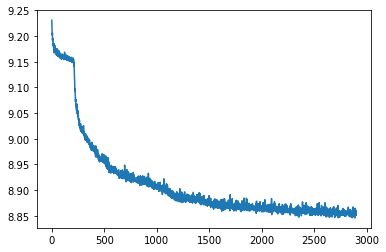

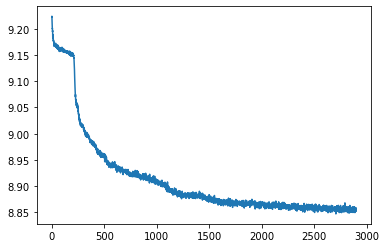

In [ ]:
plt.plot(np.log(diagnostic.get_data()[0, 100:]))
plt.show()
plt.plot(np.log(diagnostic.get_data()[1, 100:]))
plt.show()

In [ ]:
stateCheckpoint = {
            'arch': "MODEL_max_stable_best",
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'best_loss': 7000,
            'epoch': 3000,
        }
# torch.save(stateCheckpoint, self.path_save_model + 'checkpoint.pth.tar')
torch.save(stateCheckpoint, "/content/drive/MyDrive/model_GEV_FINAL.pth.tar")

In [ ]:
import os
def load_model(file, model, verbose = False):
    if os.path.isfile(file):
        if verbose:
            print("=> loading checkpoint '{}'".format(file))
        checkpoint = torch.load(file)
        startEpoch = checkpoint['epoch']

        best_loss = checkpoint['best_loss']
        model.load_state_dict(checkpoint['state_dict'])   # load parameters
        # optimizer.load_state_dict(checkpoint['optimizer'])
        if verbose:
            print("=> loaded checkpoint '{}' (epoch {})".format(file, checkpoint['epoch']))
    else:
        if verbose:
            print("=> no checkpoint found at '{}'".format(file))
        model = None
        best_loss = np.inf
        startEpoch = 0

    return model, best_loss, startEpoch

from os.path import join
PATH_SAVE_DATA = "/content/drive/MyDrive/"
MODEL_NAME = "modelPDM7.pth.tar"
pathSave = join(PATH_SAVE_DATA, MODEL_NAME) if PATH_SAVE_DATA is not None and MODEL_NAME is not None else None

dataLoaderTraining = DataLoader2(X_train_tensor, y_train_tensor, 2000, maxIterations = 10)
dataLoaderTesting = DataLoader2(X_test_tensor, y_test_tensor, 2000, maxIterations = 10)

linearBlock = nn.Sequential(*[nn.Linear(8, 20), nn.Sigmoid(), # nn.BatchNorm1d(200),
                              nn.Linear(20, 10), nn.Sigmoid(), # nn.BatchNorm1d(100),
                              nn.Linear(10, 10), nn.Sigmoid(),
                              nn.Linear(10, 10), nn.Sigmoid(),
                              nn.Linear(10, 3)])

# model = Model_unique_station(linearBlock, 
#                              duration_theta_eta = False, 
#                              remove_first_input_dim = False,
#                              constrain_xi = True,
#                              model_duration = False)
model = Model_unique_station(linearBlock)

model, best_loss, startEpoch = load_model(pathSave, model)
print(best_loss, startEpoch)
if torch.cuda.is_available():   
    model = model.cuda()

7008.164 2900


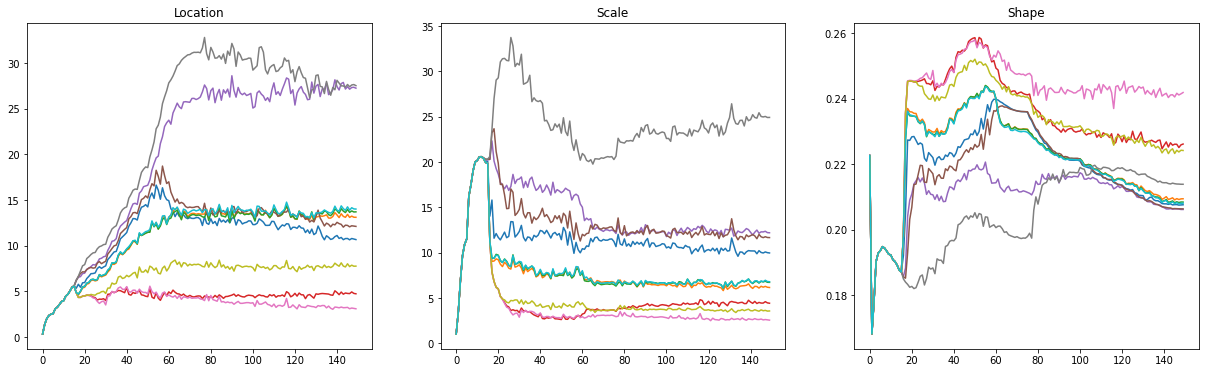

In [ ]:
nb_samples = len(results_training['estimates']['TRAINING'])
length_sample_track = len(results_training['estimates']['TRAINING'][0])

location = torch.empty((nb_samples, length_sample_track)).fill_(0)
scale = torch.empty((nb_samples, length_sample_track)).fill_(0)
shape = torch.empty((nb_samples, length_sample_track)).fill_(0)

for b in range(nb_samples):
  for j in range(length_sample_track):
    location[b, j] = results_training['estimates']['TRAINING'][b][20*j]['output_model'][0,0]
    scale[b, j] = results_training['estimates']['TRAINING'][b][20*j]['output_model'][0,1]
    shape[b, j] = results_training['estimates']['TRAINING'][b][20*j]['output_model'][0,2]

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (21,6))
for b in range(nb_samples):
  ax1.plot(location[b, :].numpy())
  ax2.plot(scale[b, :].numpy())
  ax3.plot(shape[b, :].numpy())
ax1.set_title("Location")
ax2.set_title("Scale")
ax3.set_title("Shape")

plt.show()

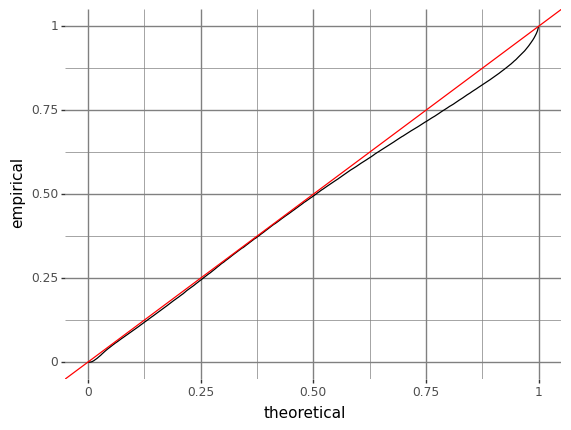

<ggplot: (8759332350029)>

In [ ]:
from os.path import join
from tqdm import tqdm
import warnings
warnings.simplefilter("ignore")

import plotnine as p9
from plotnine import ggplot, aes, geom_line, themes, labels
from plotnine import *
font_color_plot = "white"
points_color = "black" 

theme_for_the_plots = theme(plot_background = element_rect(fill = font_color_plot),
                             panel_background = element_rect(fill = "white", colour = "black"),
                             panel_grid_major = element_line(colour = "grey"),
                             panel_grid_minor = element_line(colour = "grey"),
                             legend_position = [.95, .95],            
                             legend_box_just = "right")


X_input_TEST = monthly_maxima_labelMonth[monthly_maxima_labelMonth["id"].isin(list_stations_testing)][name_covariates]
Y_output_TEST = monthly_maxima_labelMonth[monthly_maxima_labelMonth["id"].isin(list_stations_testing)][["int", "dur", "w"]]

# X_train_TEST, y_train_TEST = train_test_split(X_input_TEST,Y_output_TEST, train_size=1.0,random_state=42)
X_input_TEST.loc[:, ['X', 'Y', 'alt']] = scaler.fit_transform(X_input_TEST[['X', 'Y', 'alt']])
dataLoaderTraining = DataLoader3(torch.from_numpy(X_input_TEST.to_numpy()), 
                                 torch.from_numpy(Y_output_TEST.to_numpy()), 
                                 2000, maxIterations = 10)                      

dataLoaderTraining = DataLoader3(X_train_tensor, y_train_tensor, 2000, maxIterations = 10)
# dataLoaderTesting = DataLoader3(X_test_tensor, y_test_tensor, 2000, maxIterations = 10)

sample = dataLoaderTraining.getAlldata()
pred = model(Variable(sample['input'].float().to(device))).cpu().detach().numpy()

location = pred[:,0]
scale = pred[:,1]
shape = pred[:,2]

# location = location * (sample['output'][:,1].numpy() + pred[:,3])**(-pred[:,4])
# scale = scale * (sample['output'][:,1].numpy() + pred[:,3])**(-pred[:,4])

# location = location - (scale/shape) * (1-sample['output'][:,2].numpy()**(shape))
# scale = scale * sample['output'][:,2].numpy()**(shape)

z = (sample['output'][:,0].numpy() - location)/scale
z_standardize = np.log(1 + shape * z)/shape

qqplot_res = pd.DataFrame(data={
    "xp": (np.arange(len(z_standardize)) + 1)/(len(z_standardize)+1),
    "yp": np.exp(-np.exp(-np.sort(z_standardize))),
    "xq": np.sort(z_standardize),
    "yq": -np.log(-np.log((np.arange(len(z_standardize)) + 1)/(len(z_standardize)+1)))
})

p1 = (
    ggplot(qqplot_res) 
    + aes(x="xp", y="yp")  
    + geom_line()
    + geom_abline(intercept = 0, slope= 1, color = "red")
    + theme_for_the_plots
    + labs(x = "theoretical", y = "empirical") #"title" = "Probability plot", 
)
p1

In [ ]:
min(pred[:,2])

0.03839135

In [ ]:
z = (sample['output'][:,0].numpy() - pred[:,0])/pred[:,1]
z_standardize = np.log(1 + pred[:,2] * z)/pred[:,2]
import random

N = 1000
sample_size = 100
boot_samp_prob = np.zeros((N, sample_size))
boot_samp_quant = np.zeros((N, sample_size))

for b in range(N):
  if b % 100 == 0: print(b)
  indices_sample = np.random.choice(range(len(z)), size = sample_size, replace = False)
  Z = z_standardize[indices_sample]
  boot_samp_prob[b,:] = np.exp(-np.exp(-np.sort(Z)))
  boot_samp_quant[b,:] = np.sort(Z)

0
100
200
300
400
500
600
700
800
900


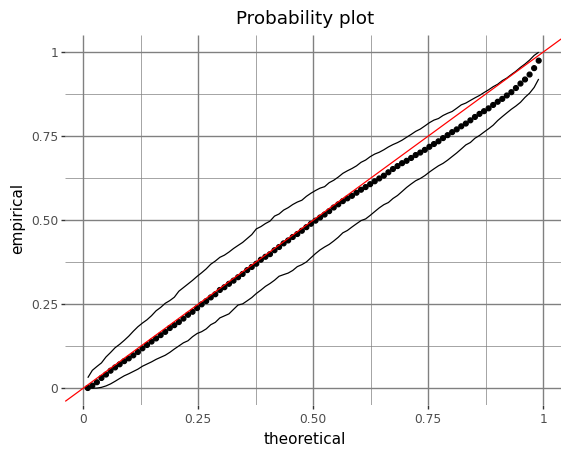

<ggplot: (8759274104525)>

In [ ]:
DF_res_prob = pd.DataFrame(boot_samp_prob)
median_prob = DF_res_prob.quantile(q=0.5, axis = 0).to_numpy()
upper_prob = DF_res_prob.quantile(q=0.975, axis = 0).to_numpy()
lower_prob = DF_res_prob.quantile(q=0.025, axis = 0).to_numpy()

DF_res_quant = pd.DataFrame(boot_samp_quant)
median_quant = DF_res_quant.quantile(q=0.5, axis = 0).to_numpy()
upper_quant = DF_res_quant.quantile(q=0.975, axis = 0).to_numpy()
lower_quant = DF_res_quant.quantile(q=0.025, axis = 0).to_numpy()

qqplot_res = pd.DataFrame(data={
    "x_prob": (np.arange(len(median_prob)) + 1)/(len(median_prob)+1),
    "median_prob": median_prob,
    "lower_prob": lower_prob,
    "upper_prob": upper_prob,

    "x_quant": -np.log(-np.log(np.arange(len(median_quant))/(len(median_quant)+1))),
    "median_quant": median_quant,
    "lower_quant": lower_quant,
    "upper_quant": upper_quant,
})

p1 = (
    ggplot(qqplot_res) 
    + aes(x="x_prob", y="median_prob")  
    + geom_point()
    + geom_line(aes(x = "x_prob", y = "lower_prob"))
    + geom_line(aes(x = "x_prob", y = "upper_prob"))
    + geom_abline(intercept = 0, slope= 1, color = "red")
    + theme_for_the_plots
    + labs(x = "theoretical", y = "empirical", title = "Probability plot") 
)
p1

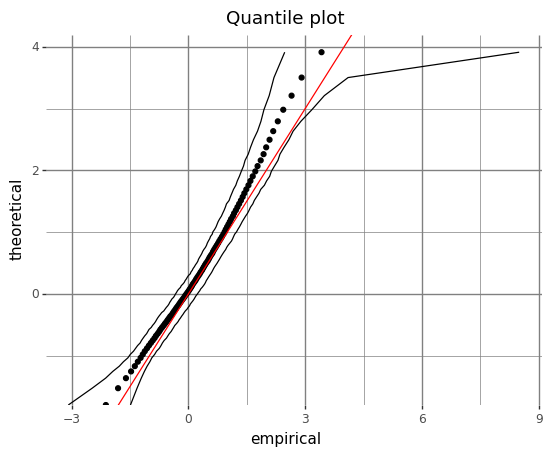

<ggplot: (8759274283897)>

In [ ]:
p2 = (
    ggplot(qqplot_res) 
    + aes(x="median_quant", y="x_quant")  
    + geom_point()
    + geom_line(aes(x = "lower_quant", y = "x_quant"))
    + geom_line(aes(x = "upper_quant", y = "x_quant"))
    + geom_abline(intercept = 0, slope= 1, color = "red")
    + theme_for_the_plots
    + labs(x = "empirical", y = "theoretical", title = "Quantile plot") 
)
p2

In [ ]:
p1.save("/content/drive/MyDrive/probability_plot_TEST_SET.pdf", height=6, width=6)
p2.save("/content/drive/MyDrive/quantile_plot_TEST_SET.pdf", height=6, width=6)

In [ ]:
def quantile(p, location, scale, shape):
  return (location + scale/shape * ((-np.log(p))**(-shape) - 1))

Station_of_interest = 69507

dat = list()
for month in range(12):
  sample_test = torch.empty((10,4 + 2*Order_basis))
  sample_test[:,3] = torch.tensor([5.0, 10.0, 15.0, 30.0, 60.0, 120.0, 180.0, 360.0, 720.0, 1440.0])
  # sample_test[:,0] = 0.1667
  # sample_test[:,1] = 0.8029
  # sample_test[:,2] = 0.2415
  sample_test[:,[0,1,2]] = torch.from_numpy(scaler.transform(monthly_maxima_labelMonth[monthly_maxima_labelMonth["id"] == Station_of_interest].iloc[:,[6, 7, 9]])[0,:]).float()
  for j in range(Order_basis):
    sample_test[:,2*j+4] = torch.empty(10).fill_(np.cos((j+1) * np.pi * 2 * month/12))
    sample_test[:,2*(j+1)+3] = torch.empty(10).fill_(np.sin((j+1) * np.pi * 2 * month/12))

  output = model(Variable(sample_test.float().to(device)))
  q_0_95 = quantile(0.95, output[:,0].cpu().detach().numpy(), output[:,1].cpu().detach().numpy(), output[:,2].cpu().detach().numpy())
  dat.append(pd.DataFrame(data={"quantile95": q_0_95,
                                "location": output[:,0].cpu().detach().numpy(),
                                "scale": output[:,1].cpu().detach().numpy(),
                                "shape": output[:,2].cpu().detach().numpy(),}))
  dat[-1]["month"] = list(calendar.month_abbr)[month+1]
  dat[-1]["month_id"] = month+1
  dat[-1]["Duration"] = tuple([5.0, 10.0, 15.0, 30.0, 60.0, 120.0, 180.0, 360.0, 720.0, 1440.0])
  # dat[month] = model(Variable(sample_test.float().cuda()))[:,0].cpu().detach().numpy()

res = pd.concat(dat)
res

,quantile95,location,scale,shape,month,month_id,Duration
0,93.326035,30.819191,15.211876,0.207889,Jan,1,5.0
1,75.898865,24.287512,12.582400,0.206816,Jan,1,10.0
2,65.677948,20.513990,11.023435,0.206102,Jan,1,15.0
3,51.846699,14.943017,8.996499,0.206836,Jan,1,30.0
4,40.615158,10.589747,7.270406,0.210961,Jan,1,60.0
...,...,...,...,...,...,...,...
5,37.305069,11.147171,6.326873,0.211640,Dec,12,120.0
6,30.958710,8.918998,5.286333,0.216743,Dec,12,180.0
7,22.065632,6.096791,3.765736,0.227049,Dec,12,360.0
8,16.203964,4.322987,2.755391,0.237133,Dec,12,720.0


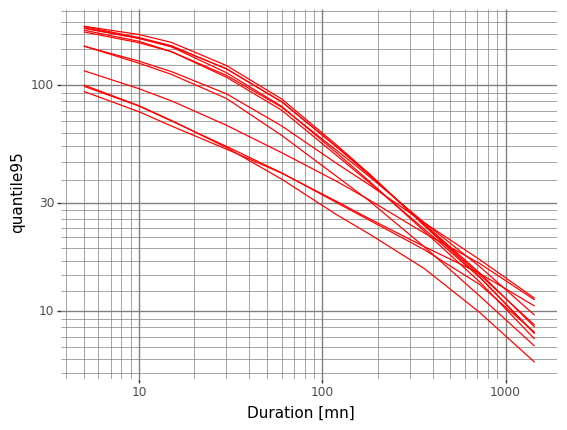

<ggplot: (8759264703105)>

In [ ]:
import plotnine as p9
(
  ggplot(data=res, mapping=p9.aes(x="Duration", y="quantile95", group = "month")) 
    + geom_line(mapping=p9.aes(x="Duration", y="quantile95", group = "month"), color = "red")
    + theme_for_the_plots
    + scale_x_continuous(trans="log10")
    + scale_y_continuous(trans="log10")
    + labs(x = "Duration [mn]", y = "quantile95") 
)

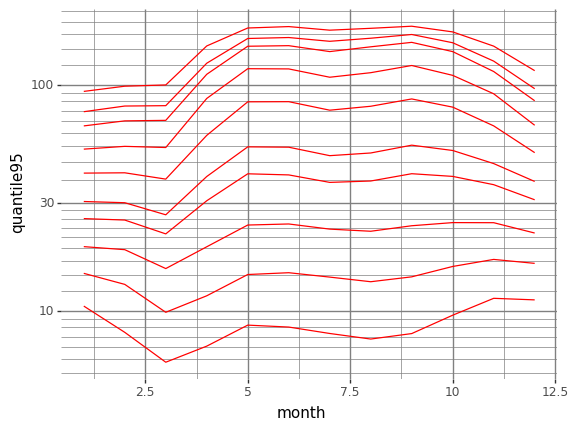

<ggplot: (8759264218657)>

In [ ]:
(
  ggplot(data=res, mapping=p9.aes(x="month_id", y="quantile95", group = "Duration")) 
    + geom_line(mapping=p9.aes(x="month_id", y="quantile95", group = "Duration"), color = "red")
    + theme_for_the_plots
    + scale_y_continuous(trans="log10")
    + labs(x = "month", y = "quantile95") 
)

In [ ]:
def create_training_datasets(proportion_station_train = 0.8,
                             train_size = 0.8,
                             seed_val = None,
                             BATCH_SIZE = 10, 
                             max_iter = 10,
                             list_stations_to_include = None):
  
  name_covariates = ["X", "Y", "alt", "dur"]
  for j in range(Order_basis):
    name_covariates.append('month_cos_'+str(j))
    name_covariates.append('month_sin_'+str(j))

  all_covariates = name_covariates.copy()
  all_covariates.extend(["id", "int", "w"])

  if list_stations_to_include is not None:
    X_input = monthly_maxima_labelMonth[monthly_maxima_labelMonth["id"].isin(list_stations_to_include)][all_covariates]
  else:
    X_input = monthly_maxima_labelMonth[all_covariates]

  # Step 1: remove random stations from the dataset
  list_stations = sorted(list(set(X_input["id"])))
  indices = np.random.choice(len(list_stations), size = int(len(list_stations) * proportion_station_train), replace = False)
  list_stations_training = [list_stations[i] for i in indices]

  mask = X_input['id'].isin(list_stations_training)
  data_input_station_training, data_input_station_testing = X_input[mask], X_input[~mask]

  X_train, X_test = train_test_split(data_input_station_training, 
                                       test_size = 1.0-train_size,
                                       random_state = seed_val)

  # X_train, X_test, y_train, y_test = train_test_split(X_input,Y_output,test_size=0.2,random_state=42)
  # X_train

  scaler = MinMaxScaler()

  
  scaler = MinMaxScaler()
  X_train.loc[:, ['X', 'Y', 'alt']] = scaler.fit_transform(X_train[['X', 'Y', 'alt']])
  X_test.loc[:, ['X', 'Y', 'alt']] = scaler.transform(X_test[['X', 'Y', 'alt']])
  if not data_input_station_testing.empty:
    data_input_station_testing.loc[:, ['X', 'Y', 'alt']] = scaler.transform(data_input_station_testing[['X', 'Y', 'alt']])

  dataloader_Training_1 = DataLoader3(torch.from_numpy(X_train[name_covariates].to_numpy()), 
                                      torch.from_numpy(X_train[["int", "dur", "w"]].to_numpy()), 
                                      BATCH_SIZE, maxIterations = max_iter)
  dataloader_Testing_1 = DataLoader3(torch.from_numpy(X_test[name_covariates].to_numpy()), 
                                     torch.from_numpy(X_test[["int", "dur", "w"]].to_numpy()), 
                                     BATCH_SIZE, maxIterations = max_iter)
  
  
  if not data_input_station_testing.empty:
    dataloader_Testing_missing_stations = DataLoader3(torch.from_numpy(data_input_station_testing[name_covariates].to_numpy()), 
                                      torch.from_numpy(data_input_station_testing[["int", "dur", "w"]].to_numpy()), 
                                      BATCH_SIZE, maxIterations = max_iter)
  else:
    dataloader_Testing_missing_stations = None

  return dataloader_Training_1, dataloader_Testing_1, dataloader_Testing_missing_stations, scaler, list_stations_training

In [ ]:
datasets = create_training_datasets()
dataloader_Training_1, dataloader_Testing_1, dataloader_Testing_missing_stations, scaler, list_stations_training = datasets

In [ ]:
# ---------- Hyperparameters ----------
LEARNING_RATE = 0.005 # 0.0001 (ModelUniqueStation), 0.001 (ModelUniqueStation1)
NUMBER_EPOCH = 200
PATH_SAVE_DATA = "/content/drive/MyDrive/"
MODEL_NAME = "model_GEV_FINAL.pth.tar"
SAVE_MODEL_FREQUENCY = 10
BATCH_SIZE = 2000 # 2000 ModelUniqueStation)

LOAD_MODEL = True
Proportion_of_stations_test = 0.1    # ~ 16 stations will be used as validation
Train_dataset_relative_size = 0.8    # 80% of observation is used for training
Nb_time_dataset_is_recreated = 10    # retrain model 10 times on a new dataset, following previous settings
Nb_bootstrapping = 5                 # for each dataset, fit model 5 times (potentially using residual bootstrapping or something similar)

# ------------------- BOOTSTRAPPING -----------------------

list_models = []
for b in range(Nb_time_dataset_is_recreated):
  
  for boot in range(Nb_bootstrapping):
    if boot == 0:
      dataLoaderTraining, dataLoaderTesting, dataLoaderTesting_unknown_stations, scaler, list_stations_training = create_training_datasets(
                                      train_size = Train_dataset_relative_size, 
                                      proportion_station_train = 1.0 - Proportion_of_stations_test, 
                                      seed_val = None, 
                                      BATCH_SIZE = BATCH_SIZE, max_iter = 10)
      
      # dataLoaderTraining = DataLoader2(X_train_tensor, y_train_tensor, BATCH_SIZE, maxIterations = 10)
      # dataLoaderTesting = DataLoader2(X_test_tensor, y_test_tensor, BATCH_SIZE, maxIterations = 10)
    else:
      sample = dataLoaderTraining.getAlldata()
      pred = model(Variable(sample['input'].float().to(device))).cpu().detach().numpy()

      location = pred[:,0]
      scale = pred[:,1]
      shape = pred[:,2]

      # when we model the duration...
      # location = location * (sample['output'][:,1].numpy() + pred[:,3])**(-pred[:,4])
      # scale = scale * (sample['output'][:,1].numpy() + pred[:,3])**(-pred[:,4])

      # when we include weights...
      # location = location - (scale/shape) * (1-sample['output'][:,2].numpy()**(shape))
      # scale = scale * sample['output'][:,2].numpy()**(shape)

      residuals = (1 - shape * (sample['output'][:,0].numpy() - location)/scale)**(1/shape)
      non_nan_residuals = residuals[~np.isnan(residuals)]
      indices_res = np.random.choice(non_nan_residuals, size = len(residuals), replace = True)
      sample_res = location - scale * (indices_res**shape - 1)/shape

      sample_output = sample['output']
      sample_output[:,0] = torch.from_numpy(sample_res)

      dataLoaderTraining = DataLoader3(sample['input'], sample_output, BATCH_SIZE, maxIterations = 10)
      # dataLoaderTesting = DataLoader3(X_test_tensor, y_test_tensor, BATCH_SIZE, maxIterations = 10)


    linearBlock = nn.Sequential(*[nn.Linear(8, 100), nn.Sigmoid(), # nn.BatchNorm1d(200),
                              nn.Linear(100, 50), nn.Sigmoid(), # nn.BatchNorm1d(100),
                              nn.Linear(50, 10), nn.Sigmoid(),
                              nn.Linear(10, 10), nn.Sigmoid(),
                              nn.Linear(10, 3)])
    modl = Model_unique_station(linearBlock)

    pathSave = join(PATH_SAVE_DATA, MODEL_NAME) if PATH_SAVE_DATA is not None and MODEL_NAME is not None else None
  
    if LOAD_MODEL:
      modl, best_loss, startEpoch = load_model(pathSave, modl)

    # if a GPU is available, move model to cuda
    if torch.cuda.is_available():   
      modl = modl.cuda()

    # Create the loss the train the model
    criterion = simpleGEVloss()

    # Optimizer
    optimizer = torch.optim.Adam(modl.parameters(), lr=LEARNING_RATE)

    # high frequency scheduler
    lr_scheduler = CyclicCosAnnealingLR(optimizer, 
                                    milestones=[100, 150, 200, 250, 300, 350, 400, 450, 
                                                500, 600, 700, 800, 900, 1000, 1500, 2000],#, 4000, 5000, 10000], 
            eta_min = LEARNING_RATE/100) # 10 (ModelUniqueStation)

    # Keep track of the loss for training and validation, and the best loss achieved w.r.t. validation score
    diagnostic = Diagnostic(channels = ["TRAINING", "TESTING"], length = NUMBER_EPOCH,
            path_figure = join(PATH_SAVE_DATA, "loss.html"), title = "Loss", xlabel = "Epoch", ylabel = "loss", 
            useTensorBoard = False, pathTensorBoard = PATH_SAVE_DATA)

    # create the trainer in order to train the model
    trainer = NeuralTrainer(
            model = modl, 
            criterion = criterion, 
            optimizer = optimizer, 
            dataloaders_dict = {"TRAINING":dataLoaderTraining, "TESTING":dataLoaderTesting}, 
            diagnostic = diagnostic, 
            scheduler = lr_scheduler, 
            path_save_model = None, 
            saveFrequency = SAVE_MODEL_FREQUENCY, 
            best_loss = None, 
            model_name = MODEL_NAME,
            referenceSaveModel = "TRAINING",
            sampleTest = 0, 
            recordFrequencySampleTest = 20, 
            progressBar = True
            )

    try:

      # train the model, and get the results, if any. There are 2 modes: one using regular SGD training, the other using stochastic weight averaging.
      results_training = trainer.trainModel_regular(
                number_of_epochs = NUMBER_EPOCH,  
                training_step = modl.train_batches,
                validation_step = modl.test_batches,
                parameters = {}
                )
      print("Training completed!")
      list_models.append(modl)
    except:
      print("Error... skipping this model")
  

Losses: {'TRAINING': 7051.251, 'TESTING': 7076.6772}: 100%|██████████| 200/200 [04:09<00:00,  1.25s/it]


Training completed!


Losses: {'TRAINING': 6933.2603, 'TESTING': 7120.807}: 100%|██████████| 200/200 [04:06<00:00,  1.23s/it]


Training completed!


  0%|          | 0/200 [00:00<?, ?it/s]


Error... skipping this model


Losses: {'TRAINING': 6930.659, 'TESTING': 7092.4346}: 100%|██████████| 200/200 [04:04<00:00,  1.22s/it]


Training completed!


Losses: {'TRAINING': 6916.2095, 'TESTING': 7055.7744}: 100%|██████████| 200/200 [04:03<00:00,  1.22s/it]


Training completed!


Losses: {'TRAINING': 7009.405, 'TESTING': 7004.0986}: 100%|██████████| 200/200 [04:02<00:00,  1.21s/it]


Training completed!


  0%|          | 0/200 [00:00<?, ?it/s]


Error... skipping this model


  0%|          | 0/200 [00:00<?, ?it/s]


Error... skipping this model


  0%|          | 0/200 [00:00<?, ?it/s]


Error... skipping this model


  0%|          | 0/200 [00:00<?, ?it/s]


Error... skipping this model


Losses: {'TRAINING': 7029.4126, 'TESTING': 7050.7617}: 100%|██████████| 200/200 [03:59<00:00,  1.20s/it]


Training completed!


  0%|          | 0/200 [00:00<?, ?it/s]


Error... skipping this model


Losses: {'TRAINING': 6883.633, 'TESTING': 7093.095}: 100%|██████████| 200/200 [03:59<00:00,  1.20s/it]


Training completed!


Losses: {'TRAINING': 7095.968, 'TESTING': 7171.0845}:   2%|▏         | 3/200 [00:03<04:12,  1.28s/it]


Error... skipping this model


  0%|          | 0/200 [00:00<?, ?it/s]


Error... skipping this model


Losses: {'TRAINING': 7030.362, 'TESTING': 6982.767}: 100%|██████████| 200/200 [03:58<00:00,  1.19s/it]


Training completed!


  0%|          | 0/200 [00:00<?, ?it/s]


Error... skipping this model


  0%|          | 0/200 [00:00<?, ?it/s]


Error... skipping this model


Losses: {'TRAINING': 6880.6704, 'TESTING': 7019.9023}: 100%|██████████| 200/200 [03:57<00:00,  1.19s/it]


Training completed!


Losses: {'TRAINING': 6881.7007, 'TESTING': 7051.186}: 100%|██████████| 200/200 [03:56<00:00,  1.18s/it]


Training completed!


Losses: {'TRAINING': 7011.203, 'TESTING': 7019.775}: 100%|██████████| 200/200 [03:56<00:00,  1.18s/it]


Training completed!


  0%|          | 0/200 [00:00<?, ?it/s]


Error... skipping this model


  0%|          | 0/200 [00:00<?, ?it/s]


Error... skipping this model


Losses: {'TRAINING': 6871.258, 'TESTING': 7068.2695}: 100%|██████████| 200/200 [03:53<00:00,  1.17s/it]


Training completed!


Losses: {'TRAINING': 6912.243, 'TESTING': 7078.931}: 100%|██████████| 200/200 [03:54<00:00,  1.17s/it]


Training completed!


Losses: {'TRAINING': 7109.764, 'TESTING': 7064.018}: 100%|██████████| 200/200 [03:54<00:00,  1.17s/it]


Training completed!


Losses: {'TRAINING': 6884.2905, 'TESTING': 7034.573}: 100%|██████████| 200/200 [03:54<00:00,  1.17s/it]


Training completed!


Losses: {'TRAINING': 6880.0547, 'TESTING': 7064.6}: 100%|██████████| 200/200 [03:55<00:00,  1.18s/it]


Training completed!


Losses: {'TRAINING': 6925.503, 'TESTING': 7072.8477}: 100%|██████████| 200/200 [03:54<00:00,  1.17s/it]


Training completed!


  0%|          | 0/200 [00:00<?, ?it/s]


Error... skipping this model


Losses: {'TRAINING': 7024.4463, 'TESTING': 7023.8726}: 100%|██████████| 200/200 [03:53<00:00,  1.17s/it]


Training completed!


Losses: {'TRAINING': 6885.2407, 'TESTING': 6988.3906}: 100%|██████████| 200/200 [03:53<00:00,  1.17s/it]


Training completed!


Losses: {'TRAINING': 6880.1377, 'TESTING': 7036.72}: 100%|██████████| 200/200 [03:54<00:00,  1.17s/it]


Training completed!


  0%|          | 0/200 [00:00<?, ?it/s]


Error... skipping this model


  0%|          | 0/200 [00:00<?, ?it/s]


Error... skipping this model


Losses: {'TRAINING': 7038.1978, 'TESTING': 7027.6}: 100%|██████████| 200/200 [03:54<00:00,  1.17s/it]


Training completed!


Losses: {'TRAINING': 6887.75, 'TESTING': 7060.543}: 100%|██████████| 200/200 [03:53<00:00,  1.17s/it]


Training completed!


  0%|          | 0/200 [00:00<?, ?it/s]


Error... skipping this model


  0%|          | 0/200 [00:00<?, ?it/s]


Error... skipping this model


  0%|          | 0/200 [00:00<?, ?it/s]


Error... skipping this model


Losses: {'TRAINING': 7054.882, 'TESTING': 6983.716}: 100%|██████████| 200/200 [03:52<00:00,  1.16s/it]


Training completed!


Losses: {'TRAINING': 6860.754, 'TESTING': 7187.4883}: 100%|██████████| 200/200 [03:53<00:00,  1.17s/it]


Training completed!


  0%|          | 0/200 [00:00<?, ?it/s]


Error... skipping this model


  0%|          | 0/200 [00:00<?, ?it/s]


Error... skipping this model


  0%|          | 0/200 [00:00<?, ?it/s]


Error... skipping this model


Losses: {'TRAINING': 7048.264, 'TESTING': 7051.267}: 100%|██████████| 200/200 [03:54<00:00,  1.17s/it]


Training completed!


Losses: {'TRAINING': 6861.3267, 'TESTING': 7062.634}: 100%|██████████| 200/200 [03:53<00:00,  1.17s/it]


Training completed!


Losses: {'TRAINING': 6884.544, 'TESTING': 7072.758}: 100%|██████████| 200/200 [03:53<00:00,  1.17s/it]


Training completed!


Losses: {'TRAINING': 6869.953, 'TESTING': 7083.464}: 100%|██████████| 200/200 [03:54<00:00,  1.17s/it]


Training completed!


Losses: {'TRAINING': 6885.9717, 'TESTING': 7064.8955}: 100%|██████████| 200/200 [03:56<00:00,  1.18s/it]

Training completed!


In [ ]:
import pickle

with open('/content/drive/MyDrive/models_2.pickle', 'wb') as handle:
    pickle.dump(list_models, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
def quantile(p, location, scale, shape):
  return (location + scale/shape * ((-np.log(p))**(-shape) - 1))

Station_of_interest = 69507

dat = list()
for month in range(12):
  sample_test = torch.empty((10,4 + 2*Order_basis))
  sample_test[:,3] = torch.tensor([5.0, 10.0, 15.0, 30.0, 60.0, 120.0, 180.0, 360.0, 720.0, 1440.0])
  sample_test[:,[0,1,2]] = torch.from_numpy(scaler.transform(monthly_maxima_labelMonth[monthly_maxima_labelMonth["id"] == Station_of_interest].iloc[:,[6, 7, 9]])[0,:]).float()
  for j in range(Order_basis):
    sample_test[:,2*j+4] = torch.empty(10).fill_(np.cos((j+1) * np.pi * 2 * month/12))
    sample_test[:,2*(j+1)+3] = torch.empty(10).fill_(np.sin((j+1) * np.pi * 2 * month/12))

  for b in range(len(list_models)):
    output = list_models[b](Variable(sample_test.float().to(device)))
    q_0_95 = quantile(0.95, output[:,0].cpu().detach().numpy(), output[:,1].cpu().detach().numpy(), output[:,2].cpu().detach().numpy())
    dat.append(pd.DataFrame(data={"quantile95": q_0_95,
                                "location": output[:,0].cpu().detach().numpy(),
                                "scale": output[:,1].cpu().detach().numpy(),
                                "shape": output[:,2].cpu().detach().numpy(),}))
    dat[-1]["month"] = list(calendar.month_abbr)[month+1]
    dat[-1]["month_id"] = month+1
    dat[-1]["Duration"] = tuple([5.0, 10.0, 15.0, 30.0, 60.0, 120.0, 180.0, 360.0, 720.0, 1440.0])
    # dat[month] = model(Variable(sample_test.float().cuda()))[:,0].cpu().detach().numpy()
    dat[-1]["Model"] = b

res = pd.concat(dat)
res

,quantile95,location,scale,shape,month,month_id,Duration,Model
0,88.203934,28.657063,14.538645,0.205905,Jan,1,5.0,0
1,73.889343,23.125778,12.430790,0.204100,Jan,1,10.0,0
2,63.968143,19.334885,10.938975,0.203577,Jan,1,15.0,0
3,48.234921,13.316907,8.514547,0.206684,Jan,1,30.0,0
4,35.820961,9.110699,6.425559,0.214943,Jan,1,60.0,0
...,...,...,...,...,...,...,...,...
5,32.304142,8.938704,5.590485,0.218246,Dec,12,120.0,28
6,25.994890,6.850911,4.530295,0.224931,Dec,12,180.0,28
7,18.535723,4.663782,3.224507,0.235751,Dec,12,360.0,28
8,12.924294,3.149993,2.226658,0.247890,Dec,12,720.0,28


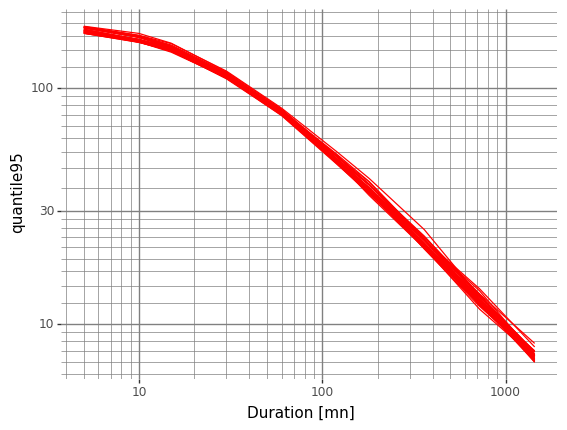

<ggplot: (8759274345929)>

In [ ]:
import plotnine as p9
from plotnine import ggplot, aes, geom_line, themes, labels
from plotnine import *
font_color_plot = "white"
points_color = "black" 

theme_for_the_plots = theme(plot_background = element_rect(fill = font_color_plot),
                             panel_background = element_rect(fill = "white", colour = "black"),
                             panel_grid_major = element_line(colour = "grey"),
                             panel_grid_minor = element_line(colour = "grey"),
                             legend_position = [.95, .95],            
                             legend_box_just = "right",
                           )

(
  ggplot(data=res[res["month"] == "Aug"], mapping=p9.aes(x="Duration", y="quantile95", group = "Model")) 
    + geom_line(mapping=p9.aes(x="Duration", y="quantile95", group = "Model"), color = "red")
    + theme_for_the_plots
    + scale_x_continuous(trans="log10")
    + scale_y_continuous(trans="log10")
    + labs(x = "Duration [mn]", y = "quantile95") 
)

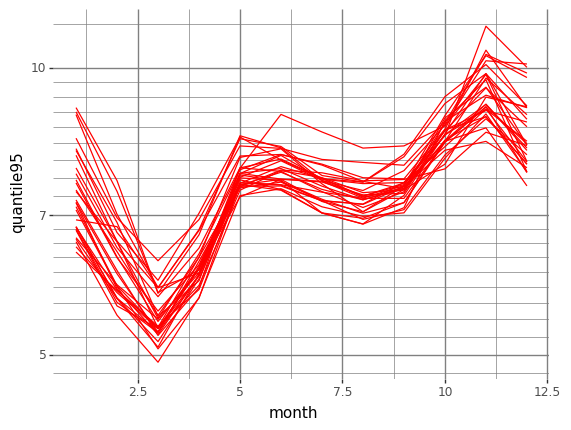

<ggplot: (8759264450993)>

In [ ]:
(
  ggplot(data=res[res["Duration"] == 1440.0], mapping=p9.aes(x="month_id", y="quantile95", group = "Model")) 
    + geom_line(mapping=p9.aes(x="month_id", y="quantile95", group = "Model"), color = "red")
    + theme_for_the_plots
    + scale_y_continuous(trans="log10")
    + labs(x = "month", y = "quantile95") 
)

In [ ]:
all_stations = list(set(monthly_maxima["id"]))

def quantile(p, location, scale, shape):
  return (location + scale/shape * ((-np.log(p))**(-shape) - 1))

dat_all = list()
for s in tqdm(range(len(all_stations))):

  dat = list()
  for month in range(12):
    sample_test = torch.empty((10,4 + 2*Order_basis))
    sample_test[:,3] = torch.tensor([5.0, 10.0, 15.0, 30.0, 60.0, 120.0, 180.0, 360.0, 720.0, 1440.0])
    sample_test[:,[0,1,2]] = torch.from_numpy(scaler.transform(monthly_maxima_labelMonth[monthly_maxima_labelMonth["id"] == all_stations[s]].iloc[:,[6, 7, 9]])[0,:]).float()
    for j in range(Order_basis):
      sample_test[:,2*j+4] = torch.empty(10).fill_(np.cos((j+1) * np.pi * 2 * month/12))
      sample_test[:,2*(j+1)+3] = torch.empty(10).fill_(np.sin((j+1) * np.pi * 2 * month/12))

    for b in range(len(list_models)):
      output = list_models[b](Variable(sample_test.float().to(device)))
      q_0_95 = quantile(0.95, output[:,0].cpu().detach().numpy(), output[:,1].cpu().detach().numpy(), output[:,2].cpu().detach().numpy())
      dat.append(pd.DataFrame(data={"quantile95": q_0_95,
                                "location": output[:,0].cpu().detach().numpy(),
                                "scale": output[:,1].cpu().detach().numpy(),
                                "shape": output[:,2].cpu().detach().numpy(),}))
      dat[-1]["month"] = list(calendar.month_abbr)[month+1]
      dat[-1]["month_id"] = month+1
      dat[-1]["Duration"] = tuple([5.0, 10.0, 15.0, 30.0, 60.0, 120.0, 180.0, 360.0, 720.0, 1440.0])
      # dat[month] = model(Variable(sample_test.float().cuda()))[:,0].cpu().detach().numpy()
      dat[-1]["Model"] = b
      dat[-1]["id"] = all_stations[s]
  res = pd.concat(dat)
  dat_all.append(res)


100%|██████████| 160/160 [21:20<00:00,  8.00s/it]


In [ ]:
pd.concat(dat_all)

,quantile95,location,scale,shape,month,month_id,Duration,Model,id
0,84.465347,23.505722,14.887635,0.205739,Jan,1,5.0,0,69632.0
1,70.315491,18.812626,12.607246,0.204323,Jan,1,10.0,0,69632.0
2,60.565819,15.552022,11.014224,0.204577,Jan,1,15.0,0,69632.0
3,43.783611,10.138875,8.155005,0.210347,Jan,1,30.0,0,69632.0
4,29.735123,6.452888,5.538891,0.221712,Jan,1,60.0,0,69632.0
...,...,...,...,...,...,...,...,...,...
5,24.419449,5.703194,4.411939,0.227281,Dec,12,120.0,28,69630.0
6,19.659748,4.479540,3.538472,0.234066,Dec,12,180.0,28,69630.0
7,14.020834,3.107953,2.497155,0.245209,Dec,12,360.0,28,69630.0
8,9.563364,2.004755,1.693695,0.257786,Dec,12,720.0,28,69630.0


In [ ]:
pd.concat(dat_all).to_csv("/content/drive/MyDrive/pred_model_GEV_all.csv", index=False)

Extension to any location on the map

In [ ]:
locations_df = pd.read_csv("/content/drive/MyDrive/elevation_map.csv")
locations_df.drop("Unnamed: 0", inplace = True, axis=1)
locations_df.rename({"long":"X", "lat":"Y", "alt":"alt"}, inplace=True, axis=1)
locations_df

,X,Y,alt
0,-85.997917,11.197917,-82
1,-85.993750,11.197917,-82
2,-85.989583,11.197917,-81
3,-85.985417,11.197917,-80
4,-85.981250,11.197917,-79
...,...,...,...
645115,-82.518750,8.002083,-118
645116,-82.514583,8.002083,-116
645117,-82.510417,8.002083,-115
645118,-82.506250,8.002083,-114


In [ ]:
# list_durations = [5.0, 10.0, 15.0, 30.0, 60.0, 120.0, 180.0, 360.0, 720.0, 1440.0]
# list_months = list(calendar.month_abbr)[1:13]
list_durations = [1440.0]
list_months = list(calendar.month_abbr)[1:13]
list_df = []
for d in range(len(list_durations)):
  for m in range(len(list_months)):
    df = locations_df.copy()
    df['dur'] = list_durations[d]
    df['month'] = list_months[m]
    list_df.append(df)

large_df_pred = pd.concat(list_df)
large_df_pred

,X,Y,alt,dur,month
0,-85.997917,11.197917,-82,1440.0,Jan
1,-85.993750,11.197917,-82,1440.0,Jan
2,-85.989583,11.197917,-81,1440.0,Jan
3,-85.985417,11.197917,-80,1440.0,Jan
4,-85.981250,11.197917,-79,1440.0,Jan
...,...,...,...,...,...
645115,-82.518750,8.002083,-118,1440.0,Dec
645116,-82.514583,8.002083,-116,1440.0,Dec
645117,-82.510417,8.002083,-115,1440.0,Dec
645118,-82.506250,8.002083,-114,1440.0,Dec


In [ ]:
look_up = {'01': 'Jan', '02': 'Feb', '03': 'Mar', '04': 'Apr', '05': 'May',
            '06': 'Jun', '07': 'Jul', '08': 'Aug', '09': 'Sep', '10': 'Oct', '11': 'Nov', '12': 'Dec'}
look_up_inv = {v: int(i) for i, (k, v) in enumerate(look_up.items())}
large_df_pred['month'] = large_df_pred['month'].map(look_up_inv)

for j in range(Order_basis):
    large_df_pred['month_cos_'+str(j)] = np.cos((j+1)*2*np.pi * large_df_pred['month'] / 12)
    large_df_pred['month_sin_'+str(j)] = np.sin((j+1)*2*np.pi * large_df_pred['month'] / 12)
large_df_pred = large_df_pred[large_df_pred["alt"] >= 0]
large_df_pred

,X,Y,alt,dur,month,month_cos_0,month_sin_0,month_cos_1,month_sin_1
40,-85.831250,11.197917,13,1440.0,0,1.000000,0.0,1.0,0.000000
41,-85.827083,11.197917,31,1440.0,0,1.000000,0.0,1.0,0.000000
42,-85.822917,11.197917,69,1440.0,0,1.000000,0.0,1.0,0.000000
43,-85.818750,11.197917,86,1440.0,0,1.000000,0.0,1.0,0.000000
44,-85.814583,11.197917,40,1440.0,0,1.000000,0.0,1.0,0.000000
...,...,...,...,...,...,...,...,...,...
640830,-82.872917,8.022917,0,1440.0,11,0.866025,-0.5,0.5,-0.866025
641668,-82.881250,8.018750,15,1440.0,11,0.866025,-0.5,0.5,-0.866025
641669,-82.877083,8.018750,22,1440.0,11,0.866025,-0.5,0.5,-0.866025
642509,-82.877083,8.014583,15,1440.0,11,0.866025,-0.5,0.5,-0.866025


In [ ]:
name_covariates = ["X", "Y", "alt", "dur"]
for j in range(Order_basis):
  name_covariates.append('month_cos_'+str(j))
  name_covariates.append('month_sin_'+str(j))

large_df_pred.loc[:, ['X', 'Y', 'alt']] = scaler.transform(large_df_pred[['X', 'Y', 'alt']])
large_df_pred_tensor = torch.from_numpy(large_df_pred[name_covariates].to_numpy())
large_df_pred_tensor.shape

torch.Size([3617364, 8])

In [ ]:
output = model(Variable(large_df_pred_tensor.float().to(device)))

In [ ]:
large_df_pred[["location", "scale", "shape"]] = output.cpu().detach().numpy()
large_df_pred.loc[:, ['X', 'Y', 'alt']] = scaler.inverse_transform(large_df_pred[['X', 'Y', 'alt']])

In [ ]:
large_df_pred

,X,Y,alt,dur,month,month_cos_0,month_sin_0,month_cos_1,month_sin_1,location,scale,shape
40,-85.831250,11.197917,13.0,1440.0,0,1.000000,0.0,1.0,0.000000,1.368136,1.334220,0.144094
41,-85.827083,11.197917,31.0,1440.0,0,1.000000,0.0,1.0,0.000000,1.367869,1.334135,0.144096
42,-85.822917,11.197917,69.0,1440.0,0,1.000000,0.0,1.0,0.000000,1.366529,1.333688,0.144107
43,-85.818750,11.197917,86.0,1440.0,0,1.000000,0.0,1.0,0.000000,1.366315,1.333621,0.144108
44,-85.814583,11.197917,40.0,1440.0,0,1.000000,0.0,1.0,0.000000,1.369484,1.334699,0.144083
...,...,...,...,...,...,...,...,...,...,...,...,...
640830,-82.872917,8.022917,0.0,1440.0,11,0.866025,-0.5,0.5,-0.866025,1.652945,1.433693,0.141890
641668,-82.881250,8.018750,15.0,1440.0,11,0.866025,-0.5,0.5,-0.866025,1.651920,1.433326,0.141898
641669,-82.877083,8.018750,22.0,1440.0,11,0.866025,-0.5,0.5,-0.866025,1.652041,1.433372,0.141897
642509,-82.877083,8.014583,15.0,1440.0,11,0.866025,-0.5,0.5,-0.866025,1.651995,1.433354,0.141898


In [ ]:
month_of_interest = 0
duration_of_interest = 1440.0

large_df_pred_interest = large_df_pred[(large_df_pred["month"] == month_of_interest) & 
                                       (large_df_pred["dur"] == duration_of_interest)]

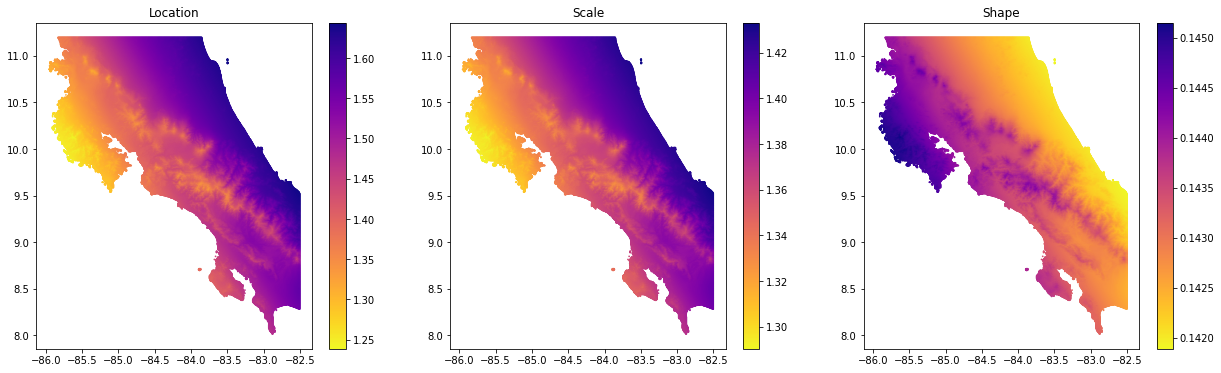

In [ ]:
import matplotlib.cm as cm
import matplotlib as mpl

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (21,6))

im1 = ax1.scatter(large_df_pred_interest['X'], large_df_pred_interest['Y'], c=large_df_pred_interest["location"], cmap='plasma_r', s = 0.5)
fig.colorbar(im1, ax=ax1, orientation='vertical')
ax1.set_title("Location")

im2 = ax2.scatter(large_df_pred_interest['X'], large_df_pred_interest['Y'], c=large_df_pred_interest["scale"], cmap='plasma_r', s = 0.5)
fig.colorbar(im2, ax=ax2, orientation='vertical')
ax2.set_title("Scale")

im3 = ax3.scatter(large_df_pred_interest['X'], large_df_pred_interest['Y'], c=large_df_pred_interest["shape"], cmap='plasma_r', s = 0.5)
fig.colorbar(im3, ax=ax3, orientation='vertical')
ax3.set_title("Shape")

plt.show()

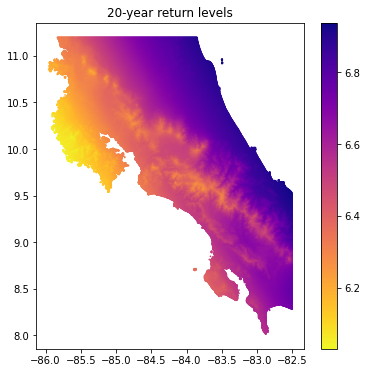

In [ ]:
return_095 = (large_df_pred_interest["location"] + large_df_pred_interest["scale"]/large_df_pred_interest["shape"] * 
              ((-np.log(0.95))**(-large_df_pred_interest["shape"]) - 1.0))

fig, ax1 = plt.subplots(1, 1, figsize = (6,6))

im1 = ax1.scatter(large_df_pred_interest['X'], large_df_pred_interest['Y'], c=return_095, cmap='plasma_r', s = 0.5)
fig.colorbar(im1, ax=ax1, orientation='vertical')
ax1.set_title("20-year return levels")

plt.show()